In [49]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors 

%matplotlib widget

In [64]:
def GetDeltas(df_meta):
    filtered_df = df_meta[df_meta["label"].str.contains("Delta", na=False)]

    return filtered_df


def GetLargestDelta(df_meta):
    filtered_df = df_meta[df_meta["label"].str.contains("Delta", na=False)]

    # Get the max energy value per event
    max_energy_per_event = filtered_df.groupby("event_id")["energy"].transform("max")

    # Keep only rows where energy matches the max per event
    return filtered_df[filtered_df["energy"] == max_energy_per_event]

def GetBrems(df_meta):
    filtered_df = df_meta[df_meta["label"].str.contains("Brem", na=False)]

    return filtered_df

# Gets the sum of the primary track and the delta energies
def GetTrackDeltaEnergy(df_meta):
    # Filter events with brem in the name
    filtered_df = df_meta[ ~df_meta["label"].str.contains("Brem", na=False)]
    filtered_df =filtered_df[filtered_df.energy>0.01]
    trk_energies = filtered_df.groupby(["event_id"])["energy"].sum()
    return trk_energies.values


def FOM(eff, bkg_eff):
    return eff/np.sqrt(bkg_eff)

def CalcEfficiency(n, N, label):
    efficiency = n/N
    error=np.sqrt( (efficiency/N) * (1-efficiency)  )

    if (label == "Bkg"):
        print(f"Bkg Rej: {label}:", round(100*efficiency, 2), "+/-", round(100*error,2),  "%", "     (bkg rej ==", round(100-100*efficiency,2), "%)")
    else:
        print(f"Efficiency {label}:",  round(100*efficiency, 2), " +/-", round(100*error,2),  "%")

    return efficiency, error


# Cut out events with Brem in the name
def ApplyEventEnergyCut(df_meta, df_primary, E_res):

    event_energy = df_meta.groupby("event_id").energy.sum()

    if (E_res == 0.5):
        good_events = event_energy[(event_energy >= 2.454) & (event_energy <= 2.471)].index # 0.5%
    else:
        good_events = event_energy[(event_energy >= 2.433) & (event_energy <= 2.48)].index # 1.0%
    df_meta = df_meta[df_meta["event_id"].isin(good_events)]
    df_primary = df_primary[df_primary["event_id"].isin(good_events)]

    return df_meta, df_primary

# Function to compute count-based ratio per event_id
def compute_ratio(group):
    # Group 1: Count of Primary + Delta*
    count_group1 = group[group["label"].str.startswith(("Primary", "Delta"))].shape[0]

    # Group 2: Count of Brem* where 0.025 < energy < 0.035 (X-rays)
    count_xrays = group[(group["label"].str.startswith("Brem")) & (group["energy"].between(0.025, 0.035))].shape[0]

    # Group 3: Count of Brem* where energy ≤ 0.025 or ≥ 0.035
    count_group3 = group[(group["label"].str.startswith("Brem")) & (~group["energy"].between(0.025, 0.035))].shape[0]

    # Compute ratio
    ratio = count_xrays / (count_group1 + count_group3)
    
    return ratio

# applies cuts to the delta, brem and primary+delta energies
def ApplyGeneralCuts(df_meta, df_primary, cut_brem, cut_delta, cut_trk_e):

    brems  = GetBrems(df_meta)

    brems = brems[brems.energy > cut_brem] # these are events to cut

    df_meta = df_meta[~df_meta.event_id.isin(brems.event_id.unique())]
    df_primary = df_primary[~df_primary.event_id.isin(brems.event_id.unique())]

    deltas  = GetDeltas(df_meta)

    deltas = deltas[deltas.energy > cut_delta] # these are events to cut

    df_meta = df_meta[~df_meta.event_id.isin(deltas.event_id.unique())]
    df_primary = df_primary[~df_primary.event_id.isin(deltas.event_id.unique())]


    filtered_df = df_meta[ ~df_meta["label"].str.contains("Brem", na=False)]
    filtered_df =filtered_df[filtered_df.energy>0.01]
    trk_energies = filtered_df.groupby(["event_id"])["energy"].sum()
    trk_energies = trk_energies[trk_energies > cut_trk_e]
    unique_events_list = trk_energies.index.unique().tolist()

    df_meta = df_meta[~df_meta.event_id.isin(unique_events_list)]
    df_primary = df_primary[~df_primary.event_id.isin(unique_events_list)]

    return df_meta, df_primary

def ApplyDeltaLenCut(df_meta, df_primary, cut_delta):

    deltas  = GetDeltas(df_meta)

    deltas = deltas[deltas.length > cut_delta] # these are events to cut

    df_meta    = df_meta[~df_meta.event_id.isin(deltas.event_id.unique())]
    df_primary = df_primary[~df_primary.event_id.isin(deltas.event_id.unique())]

    return df_meta, df_primary

# Cut out events with Brem in the name
def ApplyNTracksLenCut(df_meta, df_primary, keep_xrays):

    brems  = GetBrems(df_meta)

    if (keep_xrays):
        brems = brems[ (brems.energy < 28e-3) & (brems.energy > 30e-3) ] # these are events to cut

    df_meta    = df_meta[~df_meta.event_id.isin(brems.event_id.unique())]
    df_primary = df_primary[~df_primary.event_id.isin(brems.event_id.unique())]

    return df_meta, df_primary

def ApplyCuts(df_meta, df_primary, pressure, diffusion, mode, Eres):

    cuts = []

    # 1 bar
    if (pressure == 1):
       
        # 1bar no diff
        if (diffusion == "nodiff"):
            
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                # df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.175, 0.175, 2.5)
                # df_meta, df_primary = ApplyDeltaLenCut(df_meta,df_primary, 80)
                # cuts = (df_primary.blob2R > 0.25) & (df_primary.blob2 > 0.25) & (df_primary.blob1 > 0.25) & (df_primary.energy > 2.337) & (df_primary.energy < 2.5)  & (df_primary.Tortuosity2 > 1.1) & (df_primary.Tortuosity1 > 1.1)
                cuts = (df_primary.blob2R > 0.4) & (df_primary.blob1R > 0.4) & (df_primary.blob2 > 0.4) & (df_primary.Tortuosity2 > 1.7) 
            
            elif (mode == "nat"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                cuts = (df_primary.blob2R > 0.35) & (df_primary.blob1R > 0.35) & (df_primary.blob2 > 0.35) & (df_primary.Tortuosity2 > 1.7) & (df_primary.energy > 2.2)

            else:
                print("Unknown mode target specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 1bar 5%
        elif (diffusion == "5percent"):
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                # df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.115, 0.15, 2.5)
                # cuts = (df_primary.blob2R > 0.4) & (df_primary.energy > 2.4) & (df_primary.energy < 2.5) & (df_primary.Tortuosity2 >1.66)
                # cuts = (df_primary.blob2R > 0.4) & (df_primary.blob2 > 0.4) & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.2) & (df_primary.Tortuosity2 >1.3) & (df_primary.Tortuosity1 >1.3)
                cuts = (df_primary.blob2R > 0.34) & (df_primary.blob1R > 0.34) &  (df_primary.energy > 2.3) & (df_primary.Tortuosity2 >1.3)

            elif (mode == "simple"):
                df_meta, df_primary = ApplyNTracksLenCut(df_meta, df_primary, keep_xrays=True)
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                cuts = (df_primary.blob2R > 0.3) 

            elif (mode == "nat"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                # cuts = (df_primary.blob2R > 0.4) & (df_primary.blob2 > 0.4) & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.2) & (df_primary.Tortuosity2 >1.3) & (df_primary.Tortuosity1 >1.3)
                cuts = (df_primary.blob2R > 0.34) & (df_primary.blob1R > 0.34) &  (df_primary.energy > 2.4) & (df_primary.Tortuosity2 >1.5)

            else:
                print("Unknown efficiency target specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 1bar 0.25%
        elif (diffusion == "0.25percent"):
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                # cuts = (df_primary.blob2R > 0.35) & (df_primary.blob2 > 0.3)     & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.4) & \
                #     (df_primary.energy < 2.5) & (df_primary.Tortuosity2 > 1.6) & (df_primary.Squiglicity2 > 0.5)

                cuts = (df_primary.blob2R > 0.35) & (df_primary.blob2 > 0.35) & (df_primary.blob1R > 0.3)  & (df_primary.energy > 2.39)

            elif (mode == "nat"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                cuts = (df_primary.blob2R > 0.41) & (df_primary.blob2 > 0.45) & (df_primary.blob1R > 0.4)  & (df_primary.energy > 2.4)

            else:
                print("Unknown efficiency target specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 1bar 0.1%
        elif (diffusion == "0.1percent"):
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                # df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.08, 0.1, 2.5)
                # cuts = (df_primary.blob2R > 0.4) & (df_primary.blob2 > 0.38)     & (df_primary.blob1R > 0.44) & (df_primary.energy > 2.4) & \
                #     (df_primary.energy < 2.5) & (df_primary.Tortuosity2 > 1.6) & (df_primary.Squiglicity2 > 0.5) & (df_primary.Tortuosity1 > 1.6)

                cuts = (df_primary.blob2R > 0.3) & (df_primary.blob2 > 0.3)     & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.4)

            elif (mode == "nat"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                cuts = (df_primary.blob2R > 0.39) & (df_primary.blob2 > 0.39)     & (df_primary.blob1R > 0.39) & (df_primary.energy > 2.4)

        # -------------------------------------------------------------------------------------------------------------------------------------
        # 1bar 0.0%
        elif (diffusion == "0.0percent"):
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                # df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.13, 3, 2.5)
                cuts = (df_primary.blob2 > 0.2) & (df_primary.blob2R > 0.2) & (df_primary.blob1R > 0.2) & (df_primary.energy > 2.25)

            elif (mode == "nat"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                cuts = (df_primary.blob2 > 0.27) & (df_primary.blob2R > 0.27) & (df_primary.blob1R > 0.27) & (df_primary.energy > 2.4)

            else:
                print("Unknown efficiency target specified")

        else:
            print("Unknown diffusion specified")
    # -------------------------------------------------------------------------------------------------------------------------------------
    # 5bar
    elif (pressure == 5):
    
        # 5 bar no diff
        if (diffusion == "nodiff"):
            
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.17, 0.17, 2.5)
                cuts = (df_primary.blob2R > 0.25) & (df_primary.blob2 > 0.35) & (df_primary.blob1 > 0.35) & (df_primary.energy > 2.3) & (df_primary.energy < 2.5)  & (df_primary.Tortuosity2 > 1.35) & (df_primary.Tortuosity1 > 1.65)
            
            else:
                print("Unknown efficiency target specified")
        # -------------------------------------------------------------------------------------------------------------------------------------
        # 5bar 5%
        elif (diffusion == "5percent"):
            
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                # df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.17, 0.17, 2.5)
                # cuts = (df_primary.blob2R > 0.25) & (df_primary.blob2 > 0.35) & (df_primary.blob1R > 0.35) & (df_primary.energy > 2.4) & (df_primary.energy < 2.5) & (df_primary.Tortuosity2 > 1.63)
                cuts = (df_primary.blob2R > 0.35) & (df_primary.blob1R > 0.35) & (df_primary.energy > 2.4) & (df_primary.Tortuosity2 > 1.3)
            
            elif (mode == "simple"):
                df_meta, df_primary = ApplyNTracksLenCut(df_meta, df_primary, keep_xrays=False)
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                cuts = (df_primary.blob2R > 0.3) & (df_primary.blob2 > 0.4) 

            elif (mode == "nat"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                # df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.17, 0.17, 2.5)
                # cuts = (df_primary.blob2R > 0.25) & (df_primary.blob2 > 0.35) & (df_primary.blob1R > 0.35) & (df_primary.energy > 2.4) & (df_primary.energy < 2.5) & (df_primary.Tortuosity2 > 1.63)
                cuts = (df_primary.blob2R > 0.37) &  (df_primary.blob2 > 0.4) & (df_primary.blob1R > 0.37) & (df_primary.energy > 2.4) & (df_primary.Tortuosity2 > 1.3) & (df_primary.Tortuosity1 > 1.1)

            else:
                print("Unknown efficiency target specified")

        else:
            print("Unknown diffusion specified")

    # -------------------------------------------------------------------------------------------------------------------------------------
    # 10bar
    elif (pressure == 10):

        # 10bar no diff
        if (diffusion == "nodiff"):
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.17, 0.17, 2.5)
                cuts = (df_primary.blob2R > 0.25) & (df_primary.blob2 > 0.25) & (df_primary.blob1 > 0.25) & (df_primary.energy > 2.1) & (df_primary.energy < 2.5)  & (df_primary.Tortuosity2 > 1.27) & (df_primary.Tortuosity1 > 1.25)
            
            else:
                print("Unknown diffusion specified")

        # -------------------------------------------------------------------------------------------------------------------------------------
        # 10bar 5%
        elif (diffusion == "5percent"):
            
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                # df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.17, 0.17, 2.5)
                # cuts = (df_primary.blob2R > 0.23) & (df_primary.blob2 > 0.23) & (df_primary.blob1 > 0.23) & (df_primary.energy > 2.4) & (df_primary.energy < 2.5)  & (df_primary.Tortuosity2 > 1.34)
                cuts = (df_primary.blob2R > 0.3) & (df_primary.blob2 > 0.23) & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.4) & (df_primary.Tortuosity2 > 1.06)

            elif (mode == "simple"):
                df_meta, df_primary = ApplyNTracksLenCut(df_meta, df_primary, keep_xrays=False)
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                cuts = (df_primary.blob2R > 0.3) & (df_primary.blob2 > 0.4) 

            elif (mode == "nat"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                # df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.17, 0.17, 2.5)
                # cuts = (df_primary.blob2R > 0.23) & (df_primary.blob2 > 0.23) & (df_primary.blob1 > 0.23) & (df_primary.energy > 2.4) & (df_primary.energy < 2.5)  & (df_primary.Tortuosity2 > 1.34)
                cuts = (df_primary.blob2R > 0.32) & (df_primary.blob2 > 0.42) & (df_primary.blob1R > 0.3) & (df_primary.energy > 2.4) & (df_primary.Tortuosity2 > 1.06)

            else:
                print("Unknown efficiency target specified")

        else:
            print("Unknown diffusion specified")

    # -------------------------------------------------------------------------------------------------------------------------------------
    # 15bar
    elif (pressure == 15):
        
        # 15bar no diff
        if (diffusion == "nodiff"):
        
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.175, 3, 2.5)
                cuts = (df_primary.blob2R > 0.4) & (df_primary.blob2 > 0.32) & (df_primary.blob1 > 0.4) & (df_primary.energy > 2.35) & (df_primary.energy < 2.5) & (df_primary.Tortuosity2 > 1.15)
            
            else:
                print("Unknown efficiency target specified")

        # -------------------------------------------------------------------------------------------------------------------------------------
        # 15bar 5%
        elif (diffusion == "5percent"):
            
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.175, 3, 2.5)
                cuts = (df_primary.blob2R > 0.32) & (df_primary.blob2 > 0.32) & (df_primary.blob1 > 0.4) & (df_primary.energy > 2.35) & (df_primary.Tortuosity2 > 1.01)


            elif (mode == "simple"):
                df_meta, df_primary = ApplyNTracksLenCut(df_meta, df_primary, keep_xrays=False)
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                cuts = (df_primary.blob2R > 0.25) & (df_primary.blob2 > 0.35) 

            elif (mode == "nat"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.175, 3, 2.5)
                cuts = (df_primary.blob2R > 0.32) & (df_primary.blob2 > 0.47) & (df_primary.blob1 > 0.4) & (df_primary.energy > 2.35) & (df_primary.Tortuosity2 > 1.01)
            
        else:
            print("Unknown diffusion specified")

    # -------------------------------------------------------------------------------------------------------------------------------------
    # 25bar
    elif (pressure == 25):

        # -------------------------------------------------------------------------------------------------------------------------------------
        # 25bar 5%
        if (diffusion == "5percent"):
            
            # All cuts
            if (mode == "all"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.1, 3, 2.5)
                cuts = (df_primary.blob2R > 0.32) & (df_primary.blob2 > 0.32) & (df_primary.blob1 > 0.3) & (df_primary.energy > 2.4) 
        
            elif (mode == "simple"):
                df_meta, df_primary = ApplyNTracksLenCut(df_meta, df_primary, keep_xrays=False)
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                cuts = (df_primary.blob2R > 0.25) & (df_primary.blob2 > 0.35) 

            elif (mode == "nat"):
                df_meta, df_primary = ApplyEventEnergyCut(df_meta, df_primary, Eres)
                df_meta, df_primary = ApplyGeneralCuts(df_meta, df_primary, 0.1, 3, 2.5)
                cuts = (df_primary.blob2R > 0.36) & (df_primary.blob2 > 0.33) & (df_primary.blob1 > 0.5) & (df_primary.energy > 2.4) 

        else:
            print("Unknown diffusion specified")

    else:
        print("Unknown pressure specified")

    return df_meta, df_primary, cuts

In [79]:
diff="5percent"


nubb_meta_1bar  = pd.read_hdf(f"../data/Trackreco/ATPC_0nubb_1bar_{diff}_reco.h5",  "meta")
nubb_meta_5bar  = pd.read_hdf(f"../data/Trackreco/ATPC_0nubb_5bar_{diff}_reco.h5",  "meta")
nubb_meta_10bar = pd.read_hdf(f"../data/Trackreco/ATPC_0nubb_10bar_{diff}_reco.h5", "meta")
nubb_meta_15bar = pd.read_hdf(f"../data/Trackreco/ATPC_0nubb_15bar_{diff}_reco.h5", "meta")
# display(nubb_meta_1bar)

Tl_meta_1bar  = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_1bar_{diff}_reco.h5",  "meta")
Tl_meta_5bar  = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_5bar_{diff}_reco.h5",  "meta")
Tl_meta_10bar = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_10bar_{diff}_reco.h5", "meta")
Tl_meta_15bar = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_15bar_{diff}_reco.h5", "meta")
# display(Tl_meta_1bar)

Bi_meta_1bar  = pd.read_hdf(f"../data/Trackreco/ATPC_Bi_1bar_{diff}_reco.h5",  "meta")
Bi_meta_5bar  = pd.read_hdf(f"../data/Trackreco/ATPC_Bi_5bar_{diff}_reco.h5",  "meta")
Bi_meta_10bar = pd.read_hdf(f"../data/Trackreco/ATPC_Bi_10bar_{diff}_reco.h5", "meta")
Bi_meta_15bar = pd.read_hdf(f"../data/Trackreco/ATPC_Bi_15bar_{diff}_reco.h5", "meta")
# display(Bi_meta_1bar)

Bkg_meta_1bar  = pd.concat([Tl_meta_1bar,  Bi_meta_1bar])
Bkg_meta_5bar  = pd.concat([Tl_meta_5bar,  Bi_meta_5bar])
Bkg_meta_10bar = pd.concat([Tl_meta_10bar, Bi_meta_10bar])
Bkg_meta_15bar = pd.concat([Tl_meta_15bar, Bi_meta_15bar])


# True tables
nubb_nexus_true = pd.read_hdf("../data/NEXUSTrue/NEXUS_True_ATPC_0nubb.h5", "trueinfo")
Bi_nexus_true   = pd.read_hdf("../data/NEXUSTrue/NEXUS_True_ATPC_Bi.h5", "trueinfo")
Tl_nexus_true   = pd.read_hdf("../data/NEXUSTrue/NEXUS_True_ATPC_Tl.h5", "trueinfo")

Bkg_nexus_true  = pd.concat([Tl_nexus_true,  Bi_nexus_true])

display(nubb_nexus_true)

display(nubb_meta_1bar)

if (diff == "nodiff"):
    diff = "smear"
elif (diff == "5percent"):
    diff = "5% CO2"
elif (diff == "0.25percent"):
    diff = "0.25% CO2"
elif (diff == "0.1percent"):
    diff = "0.1% CO2"


,event_id,TrackLength,TrackEnergy,TrackEnergy1,TrackEnergy2,TrackEnergy3,Blob1E,Blob2E,TrackDiam,CreatorProc,pressure
0,150,3456.702637,2.347862,2.124211,2.124211,2.347862,0.710816,0.618647,1146.730347,DBD,1
1,151,3524.617432,2.308884,2.308884,2.308884,2.308884,0.502201,0.500650,1696.483521,DBD,1
2,152,3897.822998,2.450433,2.450433,2.450433,2.450433,0.488096,0.479237,1851.819946,DBD,1
3,153,3616.145508,2.425646,2.280077,2.425646,2.425646,0.745710,0.411366,1213.372437,DBD,1
4,154,2986.460449,2.434496,1.728798,1.728798,2.434496,0.857471,0.548043,1303.352783,DBD,1
...,...,...,...,...,...,...,...,...,...,...,...
55,1555,196.520889,2.102357,NaN,NaN,NaN,0.550742,0.526916,67.751099,DBD,15
56,1556,218.800171,2.237682,NaN,NaN,NaN,0.842803,0.743128,78.589813,DBD,15
57,1557,208.290955,2.080983,NaN,NaN,NaN,0.777613,0.488015,68.532654,DBD,15
58,1558,182.138855,2.182764,NaN,NaN,NaN,0.881364,0.474181,53.248283,DBD,15


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,150,0,1,16,192,3250.420,2.249253,0.556003,0.303060,0.790822,0.605522,3.398026,2.282729,2.785600e+00,2.145752e+00,Primary
0,150,1,0,132,116,199.328,0.208774,0.208774,0.208774,0.000000,0.208774,2.962538,2.962538,2.340754e+00,2.340754e+00,Delta0
0,151,0,1,211,126,3482.108,2.305354,0.582083,0.498524,0.517219,0.511058,1.600467,3.111600,1.122794e+00,2.464582e+00,Primary
0,151,1,0,221,221,0.000,0.034534,0.034534,0.034534,0.034534,0.034534,0.000000,0.000000,0.000000e+00,0.000000e+00,Brem
0,151,2,0,208,217,44.992,0.118437,0.118437,0.118437,0.118437,0.118437,2.449382,2.449382,1.454547e+00,1.454547e+00,Brem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1556,0,1,79,131,3325.238,2.337638,0.571758,0.485073,0.543172,0.446504,2.875670,2.027367,1.649092e+00,1.304880e+00,Primary
0,1556,1,0,0,1,16.767,0.121927,0.121927,0.121927,0.121927,0.121927,1.000000,1.000000,2.730092e-17,2.730092e-17,Brem
0,1557,0,1,20,105,2978.696,2.461078,0.652945,0.580860,0.761722,0.476601,2.618088,2.500332,1.683830e+00,1.361158e+00,Primary
0,1558,0,1,31,125,3204.248,2.463954,0.600759,0.436942,0.537035,0.307566,2.356648,1.386283,1.421605e+00,5.606110e-01,Primary


In [102]:
plt.rcParams.update({'font.size': 12})
def PlotTrueDists(df, col, label, pressure, diff):

    uselog = False

    df = df[df.pressure == pressure]

    axs[0,0].hist(df.TrackLength*pressure, bins = np.linspace(0, 5000, 100), histtype="step", color = col, label = label);
    axs[0,0].set_xlabel("Primary Track Length * P [mm bar]")
    axs[0,0].set_ylabel("Entries")
    axs[0,0].legend()
    # axs[0,0].set_title(f"{diff}")
    if (uselog): axs[0,0].semilogy()

    axs[0,1].hist(df.TrackEnergy, bins = np.linspace(0,3,100), histtype="step", color = col, label = label);
    axs[0,1].set_xlabel("Primary Track Energy [MeV]")
    axs[0,1].set_ylabel("Entries")
    axs[0,1].legend()
    # axs[0,1].set_title(f"{diff}")
    if (uselog): axs[0,1].semilogy()

    axs[0,2].hist(df.Blob1E, bins = np.linspace(0, 1.25, 100), histtype="step", color = col, label = label);
    axs[0,2].set_xlabel("Blob 1 energy [MeV]")
    axs[0,2].set_ylabel("Entries")
    axs[0,2].legend()
    # axs[0,2].set_title(f"{diff}")
    if (uselog): axs[0,2].semilogy()

    axs[1,0].hist(df.Blob2E, bins = np.linspace(0, 1, 100), histtype="step", color = col, label = label);
    axs[1,0].set_xlabel("Blob 2 energy [MeV]")
    axs[1,0].set_ylabel("Entries")
    axs[1,0].legend()
    # axs[1,0].set_title(f"{diff}")
    if (uselog): axs[1,0].semilogy()

    axs[1,1].hist(df.TrackDiam*pressure, bins = np.linspace(0, 3000, 100), histtype="step", color = col, label = label);
    axs[1,1].set_xlabel("Primary Track Diameter * P [mm bar]")
    axs[1,1].set_ylabel("Entries")
    axs[1,1].legend()
    # axs[1,1].set_title(f"{diff}")
    if (uselog): axs[1,1].semilogy()

    plt.tight_layout()

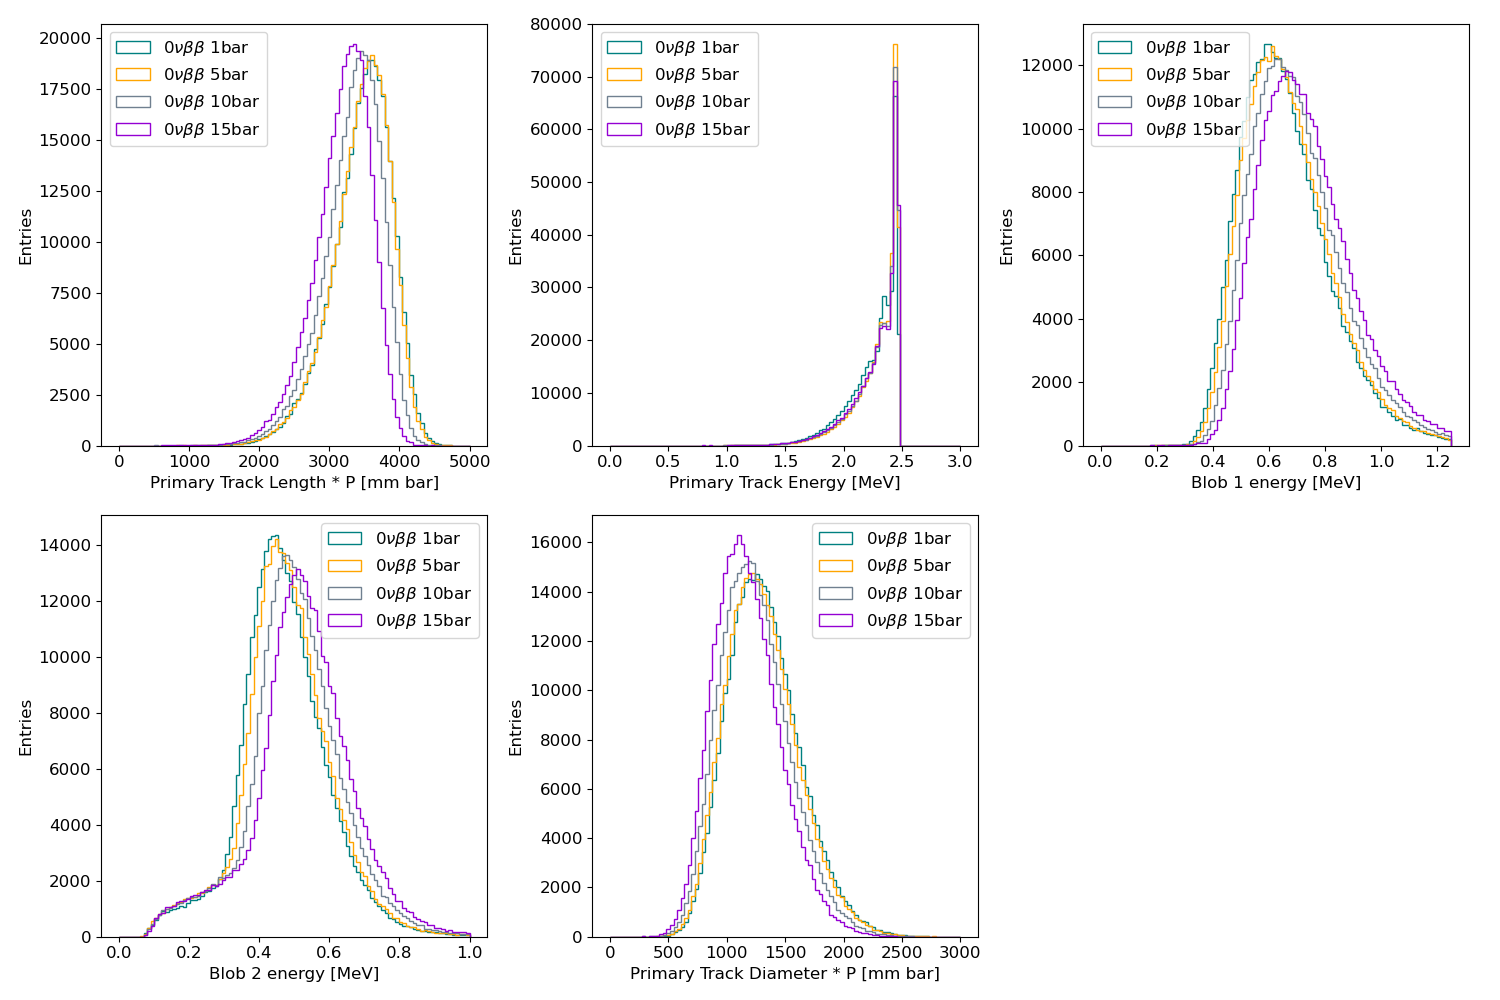

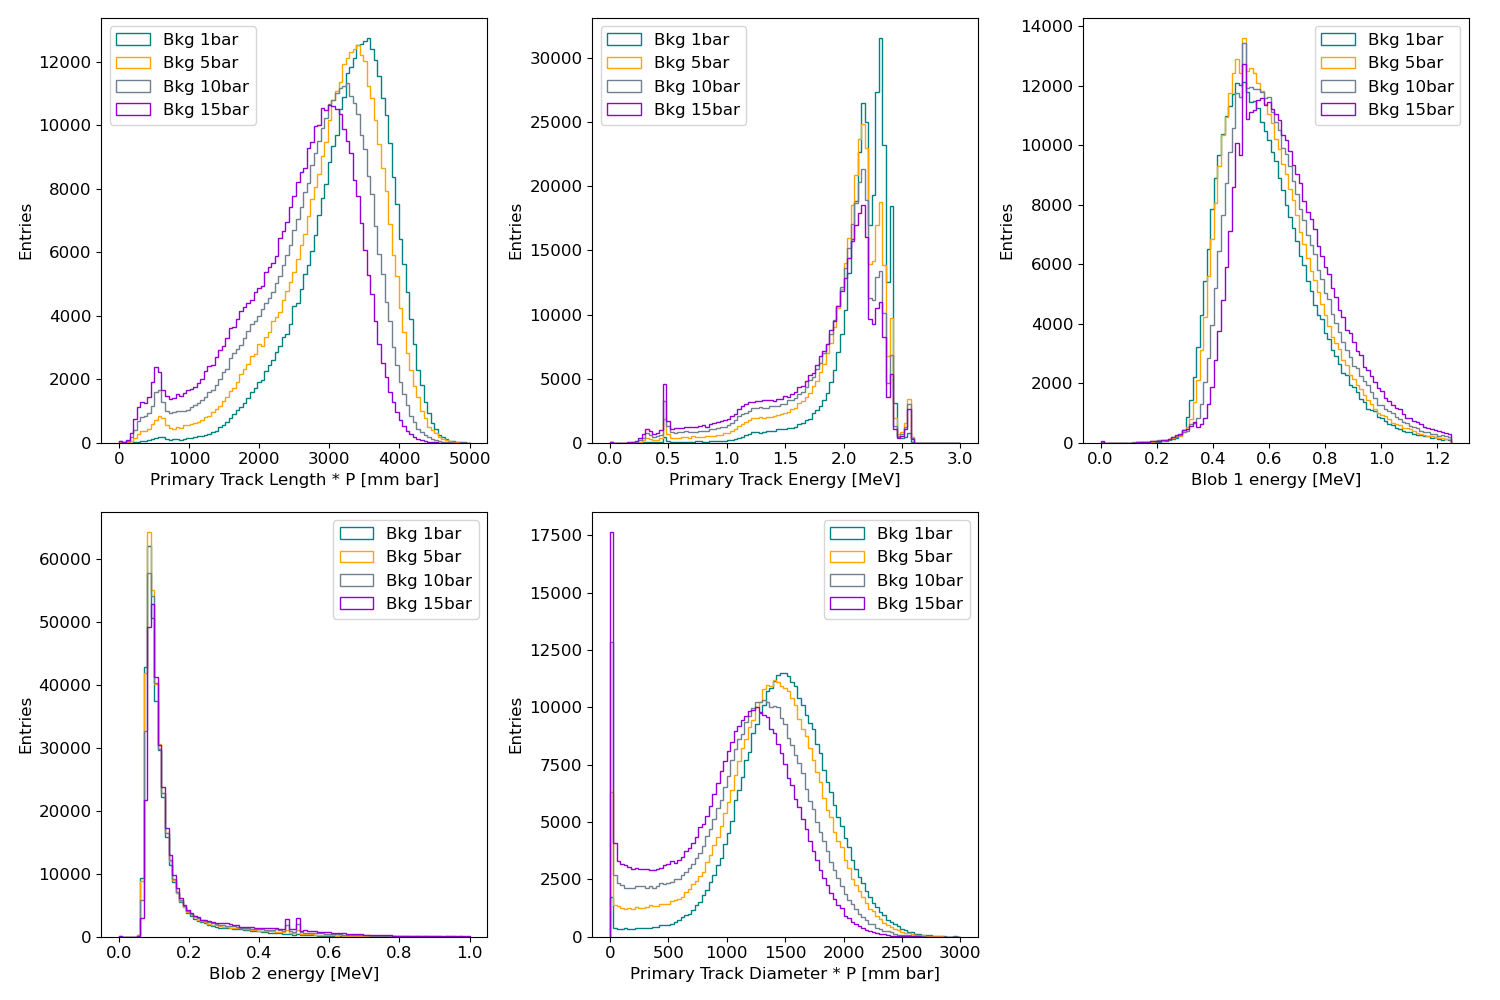

In [103]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

PlotTrueDists(nubb_nexus_true, "Teal",        r"$0\nu\beta\beta$ 1bar",  1, diff)
PlotTrueDists(nubb_nexus_true, "orange",      r"$0\nu\beta\beta$ 5bar",  5, diff)
PlotTrueDists(nubb_nexus_true, "slategray",   r"$0\nu\beta\beta$ 10bar", 10, diff)
PlotTrueDists(nubb_nexus_true, "darkviolet",  r"$0\nu\beta\beta$ 15bar", 15, diff)
axs[1,2].axis('off')
plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueDistributionsSignal.pdf")

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
PlotTrueDists(Bkg_nexus_true, "Teal",       "Bkg 1bar",  1, diff)
PlotTrueDists(Bkg_nexus_true, "orange",     "Bkg 5bar",  5, diff)
PlotTrueDists(Bkg_nexus_true, "slategray",  "Bkg 10bar", 10, diff)
PlotTrueDists(Bkg_nexus_true, "darkviolet", "Bkg 15bar", 15, diff)
axs[1,2].axis('off')
plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueDistributionsBackground.pdf")


In [83]:
def Plot2Dhist(ax, varx, vary, bins):

    hist, xedges, yedges = np.histogram2d(varx, vary, bins=bins)

    # 2. Mask zero bins
    masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

    # 3. Create a custom colormap with white for the masked values (zero bins)
    cmap = plt.cm.viridis  # Choose a colormap you like
    cmap.set_bad(color='white')  # Set masked values (zeros) to white

    # 4. Plot the 2D histogram
    pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap, norm=mcolors.LogNorm())

    # # Add color bar
    # plt.colorbar(pcm, ax=ax, label='Counts')


def PlotTrueRecoDists(df_true, df_reco, label, pressure, diff):

    uselog = True

    df_true = df_true[df_true.pressure == pressure]
    df_reco = df_reco[df_reco.primary == 1]

    # Ensure the reco and true have the same events
    df_true = df_true[df_true.event_id.isin(df_reco.event_id.unique())]
    df_reco = df_reco[df_reco.event_id.isin(df_true.event_id.unique())]

    df = pd.merge(df_true, df_reco, on='event_id', how='inner')

    Plot2Dhist(axs[0], df.TrackLength, df.length, bins = [np.linspace(0, 5000/pressure, 100), np.linspace(0, 5000/pressure, 100)])
    axs[0].set_xlabel("True Primary Track Length [mm]")
    axs[0].set_ylabel("Reco Primary Track Length [mm]")
    axs[0].set_title(f"{label} {pressure}bar {diff}")

    Plot2Dhist(axs[1], df.TrackEnergy, df.energy, bins = [np.linspace(0,3,100), np.linspace(0,3,100)])
    axs[1].set_xlabel("True Primary Track Energy [MeV]")
    axs[1].set_ylabel("Reco Primary Track Energy [MeV]")
    axs[1].set_title(f"{label} {pressure}bar {diff}")

    Plot2Dhist(axs[2], df.Blob1E, df.blob1R, bins = [np.linspace(0, 1.25, 100), np.linspace(0, 1.25, 100)])
    axs[2].set_xlabel("True Blob 1 energy [MeV]")
    axs[2].set_ylabel("Reco Blob 1 energy [MeV]")
    axs[2].set_title(f"{label} {pressure}bar {diff}")

    Plot2Dhist(axs[3], df.Blob2E, df.blob2R, bins = [np.linspace(0, 1, 100), np.linspace(0, 1, 100)])
    axs[3].set_xlabel("True Blob 2 energy [MeV]")
    axs[3].set_ylabel("Reco Blob 2 energy [MeV]")
    axs[3].set_title(f"{label} {pressure}bar {diff}")

In [84]:
# Decide to apply cuts

ApplyCutsb = False


def Selection(df_meta, pressure, diffusion, mode, eres):

    df_primary = df_meta[ (df_meta.label == "Primary") & (df_meta.primary == 1)]

    # Apply the cuts
    df_meta, df_primary, cuts = ApplyCuts(df_meta, df_primary, pressure, diffusion, mode, eres)
    
    df_primary = df_primary[ cuts ]

    df_meta = df_meta[(df_meta.event_id.isin(df_primary.event_id.unique()))]


    return df_meta

if (ApplyCutsb):
    nubb_meta_1bar = Selection(nubb_meta_1bar, 1, "5percent", "all", 0.5)
    nubb_nexus_true_1bar = nubb_nexus_true[nubb_nexus_true.pressure == 1]
    nubb_nexus_true_1bar = nubb_nexus_true_1bar[(nubb_nexus_true_1bar.event_id.isin(nubb_meta_1bar.event_id.unique()))] 

    nubb_meta_5bar = Selection(nubb_meta_5bar, 5, "5percent", "all", 0.5)
    nubb_nexus_true_5bar = nubb_nexus_true[nubb_nexus_true.pressure == 5]
    nubb_nexus_true_5bar = nubb_nexus_true_5bar[(nubb_nexus_true_5bar.event_id.isin(nubb_meta_5bar.event_id.unique()))] 

    nubb_meta_10bar = Selection(nubb_meta_10bar, 10, "5percent", "all", 0.5)
    nubb_nexus_true_10bar = nubb_nexus_true[nubb_nexus_true.pressure == 10]
    nubb_nexus_true_10bar = nubb_nexus_true_10bar[(nubb_nexus_true_10bar.event_id.isin(nubb_meta_10bar.event_id.unique()))] 

    nubb_meta_15bar = Selection(nubb_meta_15bar, 15, "5percent", "all", 0.5)
    nubb_nexus_true_15bar = nubb_nexus_true[nubb_nexus_true.pressure == 15]
    nubb_nexus_true_15bar = nubb_nexus_true_15bar[(nubb_nexus_true_15bar.event_id.isin(nubb_meta_15bar.event_id.unique()))] 


    Bkg_meta_1bar = Selection(Bkg_meta_1bar, 1, "5percent", "all", 0.5)
    Bkg_nexus_true_1bar = Bkg_nexus_true[Bkg_nexus_true.pressure == 1]
    Bkg_nexus_true_1bar = Bkg_nexus_true_1bar[(Bkg_nexus_true_1bar.event_id.isin(Bkg_meta_1bar.event_id.unique()))] 

    Bkg_meta_5bar = Selection(Bkg_meta_5bar, 5, "5percent", "all", 0.5)
    Bkg_nexus_true_5bar = Bkg_nexus_true[Bkg_nexus_true.pressure == 5]
    Bkg_nexus_true_5bar = Bkg_nexus_true_5bar[(Bkg_nexus_true_5bar.event_id.isin(Bkg_meta_5bar.event_id.unique()))] 

    Bkg_meta_10bar = Selection(Bkg_meta_10bar, 10, "5percent", "all", 0.5)
    Bkg_nexus_true_10bar = Bkg_nexus_true[Bkg_nexus_true.pressure == 10]
    Bkg_nexus_true_10bar = Bkg_nexus_true_10bar[(Bkg_nexus_true_10bar.event_id.isin(Bkg_meta_10bar.event_id.unique()))] 

    Bkg_meta_15bar = Selection(Bkg_meta_15bar, 15, "5percent", "all", 0.5)
    Bkg_nexus_true_15bar = Bkg_nexus_true[Bkg_nexus_true.pressure == 15]
    Bkg_nexus_true_15bar = Bkg_nexus_true_15bar[(Bkg_nexus_true_15bar.event_id.isin(Bkg_meta_15bar.event_id.unique()))] 


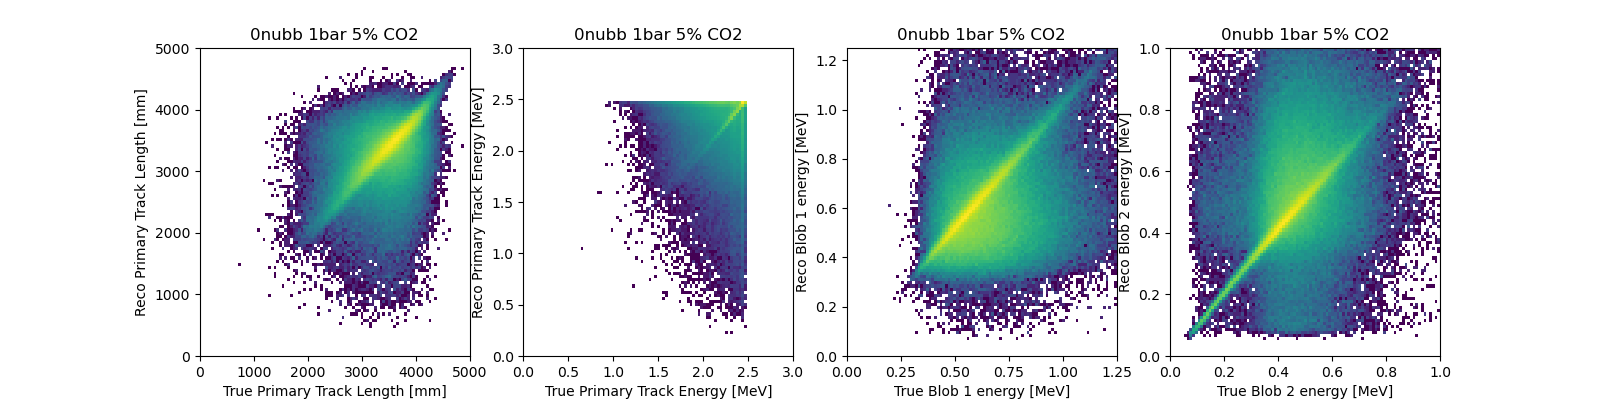

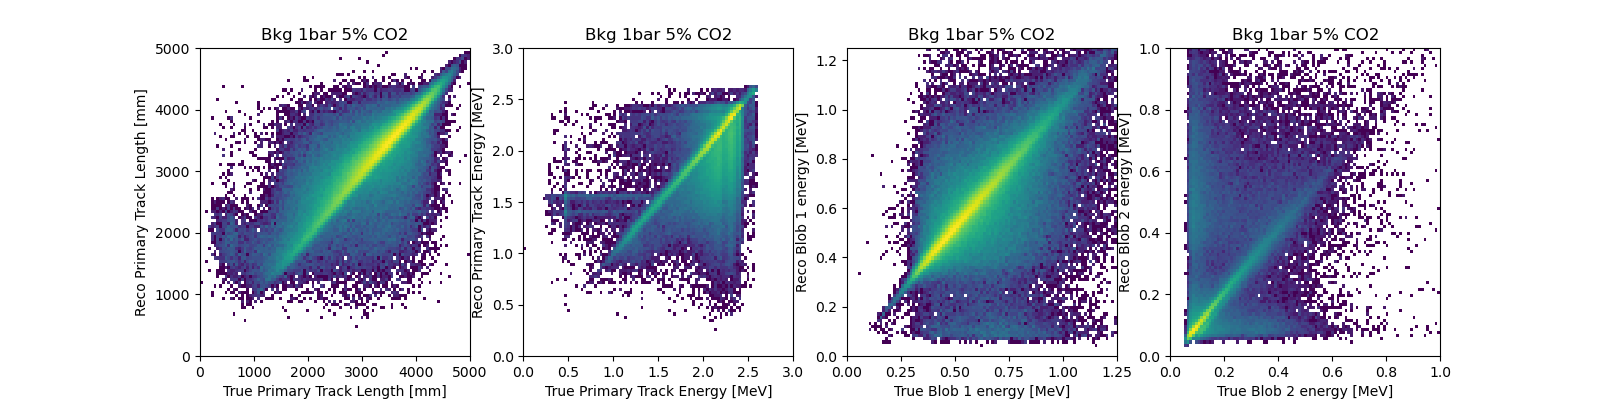

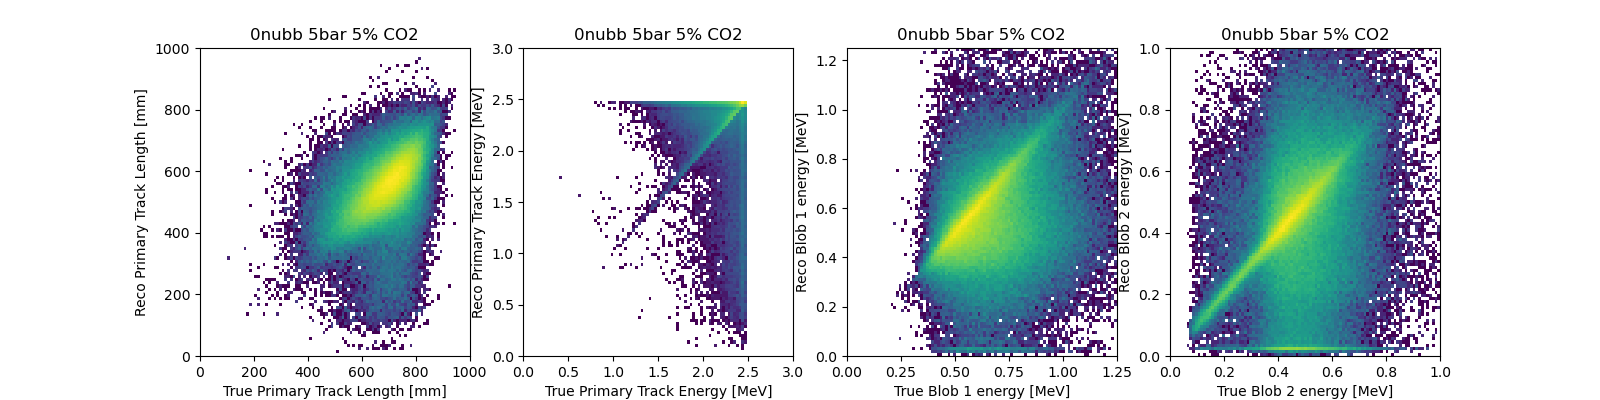

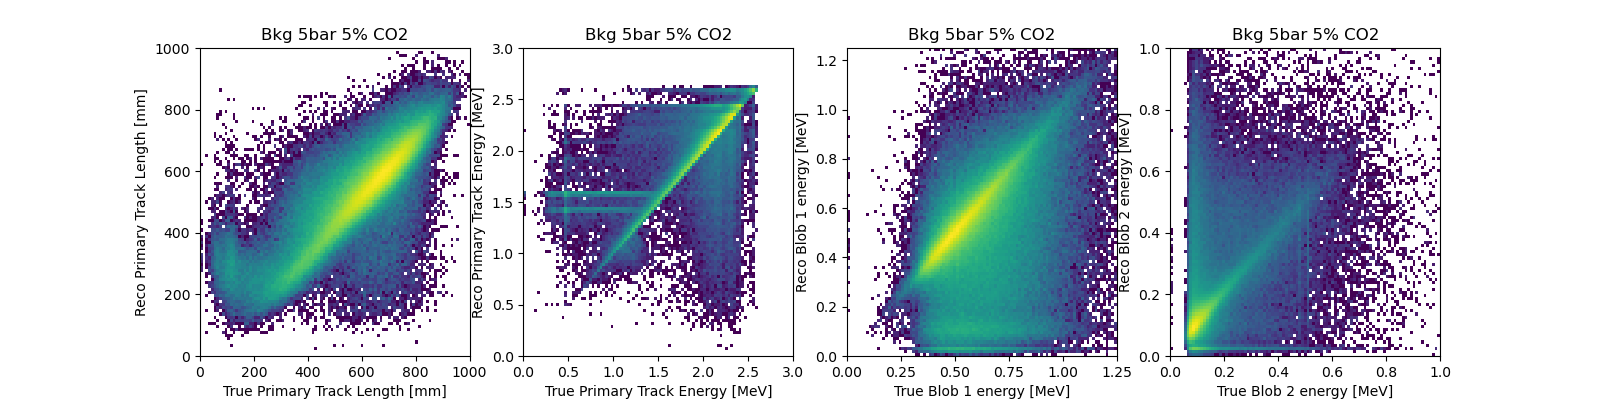

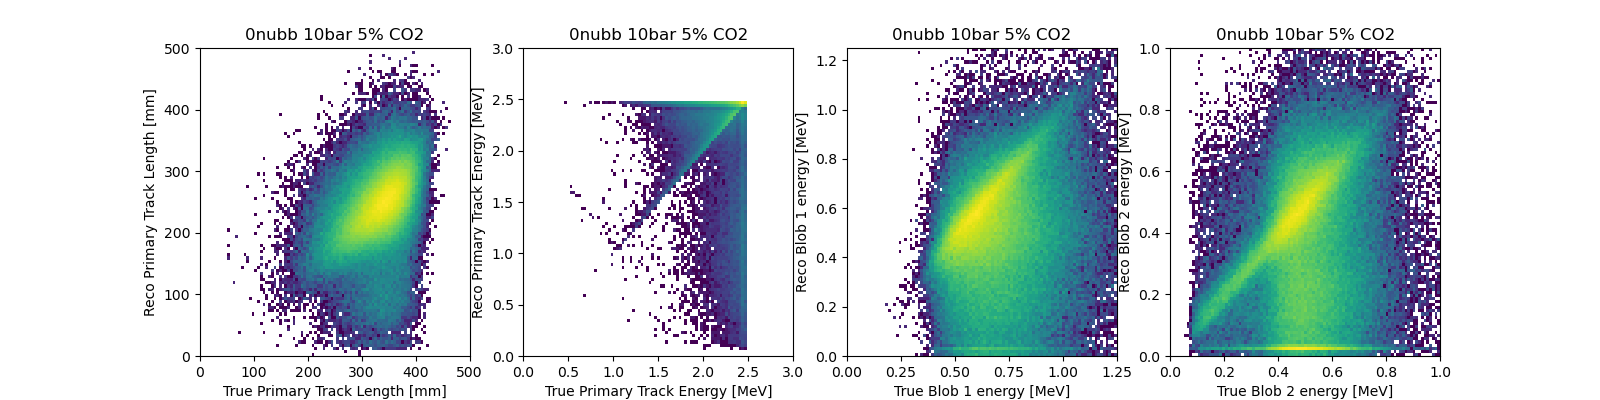

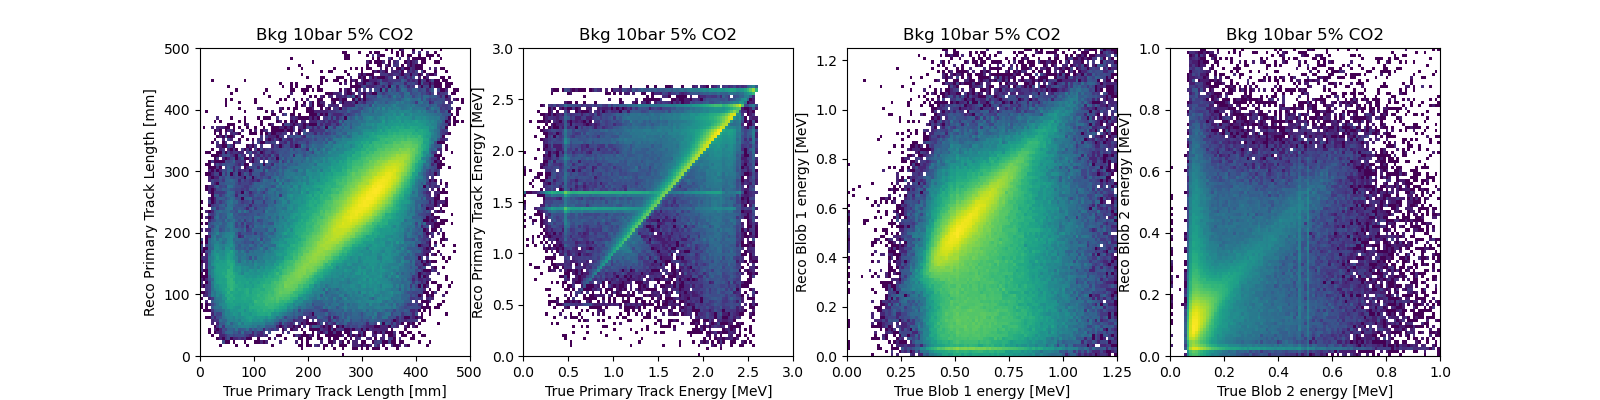

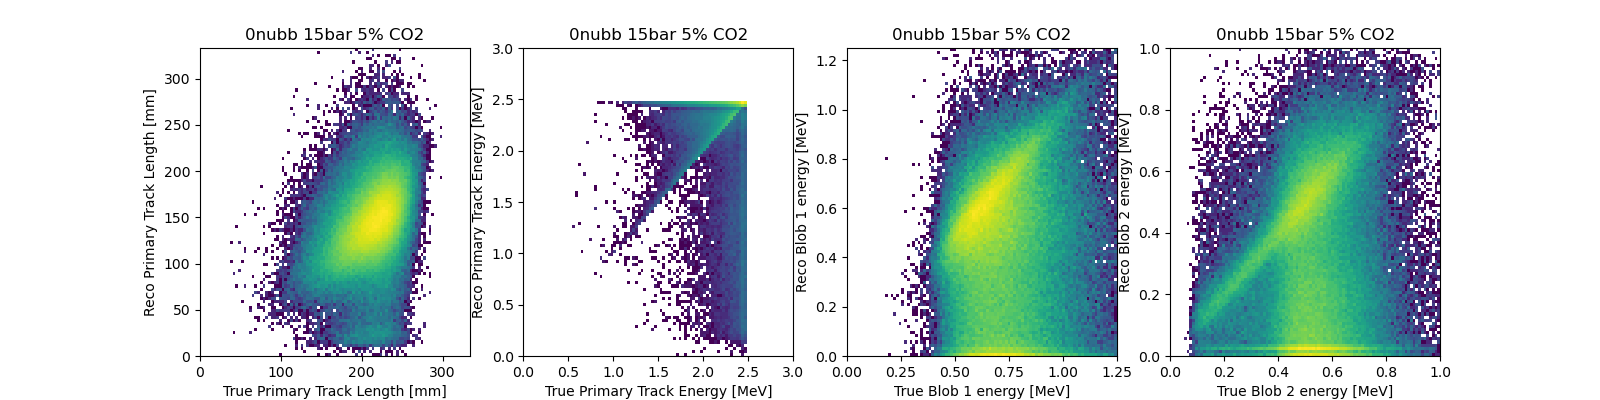

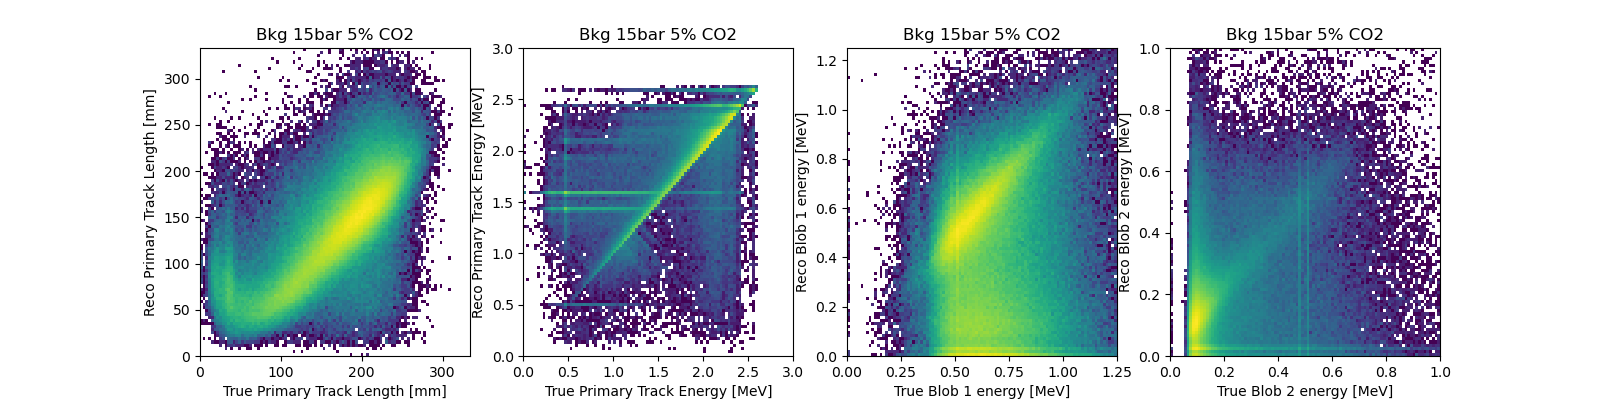

In [89]:

if (ApplyCutsb == False):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true, nubb_meta_1bar,   "0nubb", 1, diff)
    plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueReco1barSignal.pdf")
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true, Bkg_meta_1bar,   "Bkg", 1, diff)
    plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueReco1barBackground.pdf")


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true, nubb_meta_5bar,   "0nubb", 5, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true, Bkg_meta_5bar,   "Bkg", 5, diff)


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true, nubb_meta_10bar,  "0nubb", 10, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true, Bkg_meta_10bar,  "Bkg", 10, diff)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true, nubb_meta_15bar,  "0nubb", 15, diff)
    plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueReco15barSignal.pdf")
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true, Bkg_meta_15bar,  "Bkg", 15, diff)
    plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/TrueReco15barBackground.pdf")
else:
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true_1bar, nubb_meta_1bar,   "0nubb", 1, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true_1bar, Bkg_meta_1bar,   "Bkg", 1, diff)


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true_5bar, nubb_meta_5bar,   "0nubb", 5, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true_5bar, Bkg_meta_5bar,   "Bkg", 5, diff)


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true_10bar, nubb_meta_10bar,  "0nubb", 10, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true_10bar, Bkg_meta_10bar,  "Bkg", 10, diff)

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(nubb_nexus_true_15bar, nubb_meta_15bar,  "0nubb", 15, diff)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    PlotTrueRecoDists(Bkg_nexus_true_15bar, Bkg_meta_15bar,  "Bkg", 15, diff)




In [71]:
def PlotResolutions(df_true, df_reco, col, label, pressure, diff):

    uselog = False

    df_true = df_true[df_true.pressure == pressure]
    df_reco = df_reco[df_reco.primary == 1]

    # Ensure the reco and true have the same events
    df_true = df_true[df_true.event_id.isin(df_reco.event_id.unique())]
    df_reco = df_reco[df_reco.event_id.isin(df_true.event_id.unique())]

    df = pd.merge(df_true, df_reco, on='event_id', how='inner')

    res = ((df.length - df.TrackLength) / df.TrackLength).dropna()
    axs[0].hist(res, bins = np.linspace(-1,1,100),histtype="step", color = col, label = label)
    axs[0].set_xlabel("Primary Track Length Resolution")
    axs[0].set_ylabel("Entries")
    axs[0].legend()
    axs[0].set_title(f"{diff}")
    if (uselog): axs[0].semilogy()

    res = ((df.energy - df.TrackEnergy) / df.TrackEnergy).dropna()
    axs[1].hist(res, bins = np.linspace(-1,1,100), histtype="step", color = col, label = label);
    axs[1].set_xlabel("Primary Track Energy Resolution")
    axs[1].set_ylabel("Entries")
    axs[1].legend()
    axs[1].set_title(f"{diff}")
    if (uselog): axs[1].semilogy()

    res = ((df.blob1R - df.Blob1E) / df.Blob1E).dropna()
    axs[2].hist(res, bins = np.linspace(-1,1,100), histtype="step", color = col, label = label);
    axs[2].set_xlabel("Blob 1 energy Resolution")
    axs[2].set_ylabel("Entries")
    axs[2].legend()
    axs[2].set_title(f"{diff}")
    if (uselog): axs[2].semilogy()

    res = ((df.blob2R - df.Blob2E) / df.Blob2E).dropna()
    axs[3].hist(res, bins = np.linspace(-1, 1, 100), histtype="step", color = col, label = label);
    axs[3].set_xlabel("Blob 2 energy Resolution")
    axs[3].set_ylabel("Entries")
    axs[3].legend()
    axs[3].set_title(f"{diff}")
    if (uselog): axs[3].semilogy()

    plt.tight_layout()

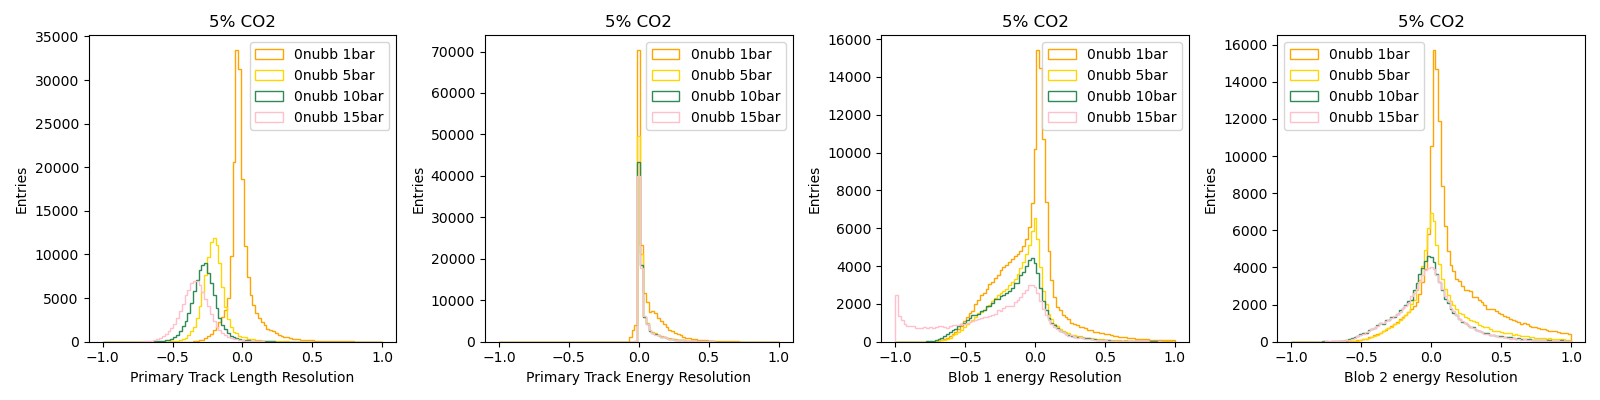

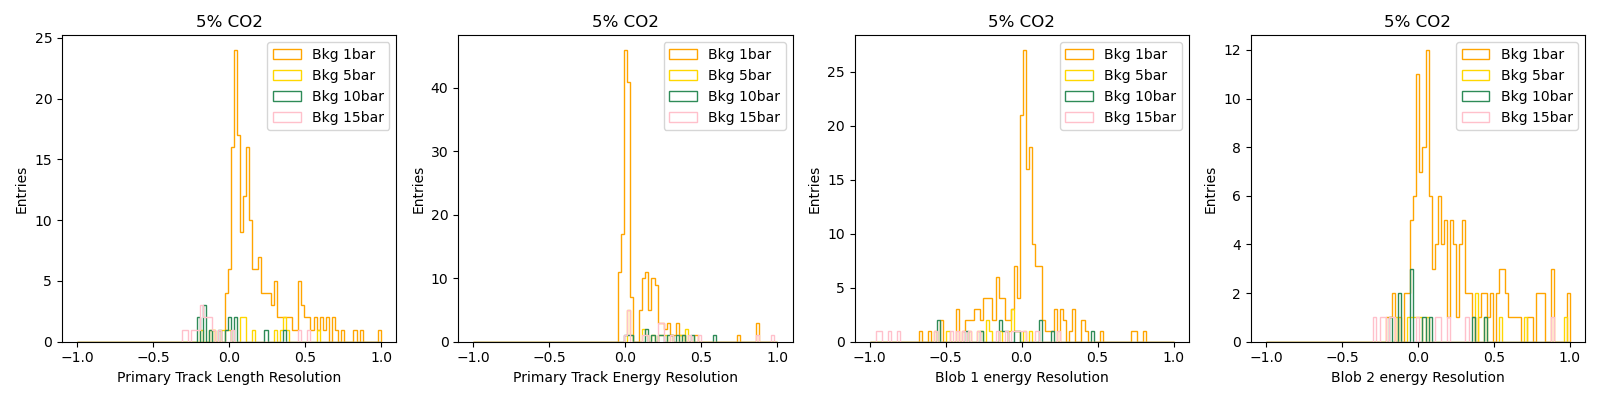

In [72]:

if (ApplyCutsb == False):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    PlotResolutions(nubb_nexus_true, nubb_meta_1bar, "orange",   "0nubb 1bar",  1, diff)
    PlotResolutions(nubb_nexus_true, nubb_meta_5bar, "gold",     "0nubb 5bar",  5, diff)
    PlotResolutions(nubb_nexus_true, nubb_meta_10bar, "seagreen", "0nubb 10bar", 10, diff)
    PlotResolutions(nubb_nexus_true, nubb_meta_15bar, "Pink",     "0nubb 15bar", 15, diff)


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    PlotResolutions(Bkg_nexus_true, Bkg_meta_1bar,  "orange",   "Bkg 1bar",  1, diff)
    PlotResolutions(Bkg_nexus_true, Bkg_meta_5bar,  "gold",     "Bkg 5bar",  5, diff)
    PlotResolutions(Bkg_nexus_true, Bkg_meta_10bar, "seagreen", "Bkg 10bar", 10, diff)
    PlotResolutions(Bkg_nexus_true, Bkg_meta_15bar, "Pink",     "Bkg 15bar", 15, diff)

else:
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    PlotResolutions(nubb_nexus_true_1bar, nubb_meta_1bar, "orange",   "0nubb 1bar",  1, diff)
    PlotResolutions(nubb_nexus_true_5bar, nubb_meta_5bar, "gold",     "0nubb 5bar",  5, diff)
    PlotResolutions(nubb_nexus_true_10bar, nubb_meta_10bar, "seagreen", "0nubb 10bar", 10, diff)
    PlotResolutions(nubb_nexus_true_15bar, nubb_meta_15bar, "Pink",     "0nubb 15bar", 15, diff)


    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    PlotResolutions(Bkg_nexus_true_1bar, Bkg_meta_1bar,  "orange",   "Bkg 1bar",  1, diff)
    PlotResolutions(Bkg_nexus_true_5bar, Bkg_meta_5bar,  "gold",     "Bkg 5bar",  5, diff)
    PlotResolutions(Bkg_nexus_true_10bar, Bkg_meta_10bar, "seagreen", "Bkg 10bar", 10, diff)
    PlotResolutions(Bkg_nexus_true_15bar, Bkg_meta_15bar, "Pink",     "Bkg 15bar", 15, diff)

In [59]:
display(Bi_nexus_true[Bi_nexus_true.pressure == 15])
print(len(Bi_nexus_true[Bi_nexus_true.pressure == 15].event_id.unique()))

,event_id,TrackLength,TrackEnergy,TrackEnergy1,TrackEnergy2,TrackEnergy3,Blob1E,Blob2E,TrackDiam,CreatorProc,pressure
0,5610000,178.511414,1.794100,1.626311,1.794100,1.794100,0.639060,0.100295,94.472221,compt,15
1,5610001,56.444164,0.913206,0.645030,0.645030,0.913206,0.762719,0.371167,22.213903,compt,15
2,5610002,183.405701,2.125948,1.781636,1.924805,2.125948,0.672750,0.455267,78.934662,compt,15
3,5610003,156.411163,1.705453,1.537336,1.705453,1.705453,0.570021,0.096616,66.182114,compt,15
4,5610004,192.736038,2.125574,1.708250,1.708250,2.125574,0.566957,0.098996,138.752075,compt,15
...,...,...,...,...,...,...,...,...,...,...,...
55,5600055,99.141373,1.239061,1.081527,1.239061,1.239061,0.531702,0.114863,53.245884,compt,15
56,5600056,146.398529,2.011474,1.430674,1.563969,2.011474,0.396545,0.115771,68.591934,compt,15
57,5600057,199.543655,1.908241,1.908241,1.908241,1.908241,0.528003,0.086533,85.239876,compt,15
58,5600058,140.055710,1.738503,1.370476,1.492073,1.738503,0.706586,0.082351,2.016074,compt,15


194400


,event_id,hit_tot_energy
0,5610000,2.447
1,5610001,2.447
2,5610002,2.447
3,5610003,2.447
4,5610004,2.447
...,...,...
55,5600055,2.447
56,5600056,2.447
57,5600057,2.447
58,5600058,2.447


14.353780825741111


,event_id,hit_tot_energy
0,1600000,2.447687
1,1600001,2.331340
2,1600002,2.380560
3,1600003,2.447687
4,1600004,2.447687
...,...,...
152,1000600152,2.447687
153,1000600153,2.447687
154,1000600154,2.447687
155,1000600155,2.447687


       event_id  hit_tot_energy
36      1600036        2.484561
43      1600043        2.542908
44      1600044        2.552064
45      1600045        2.472469
52      1600052        2.457523
..          ...             ...
21   1000600021        2.497566
40   1000600040        2.555494
81   1000600081        2.489852
85   1000600085        2.545862
135  1000600135        2.542908

[8980 rows x 2 columns]


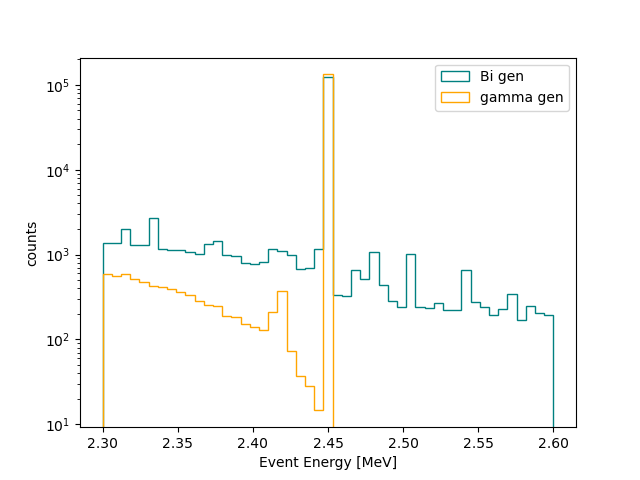

In [63]:
Bi_nexus_true_15bar = pd.read_hdf("../data/NEXUSTrue/Bi_true_files_merged.h5", "MC/E")
display(Bi_nexus_true_15bar)


N_Bi_gen = 9.96e8

N_Bi_Sample = 1e6/1.545e-2 * (194400/8766)
print(N_Bi_Sample/1e8)

weights        = np.ones_like(Bi_nexus_true_15bar.hit_tot_energy)  * N_Bi_gen/N_Bi_Sample

Bi_ion_df = pd.read_hdf("../data/NEXUSTrue/Bi_ion_files_merged.h5", "MC/E")
display(Bi_ion_df)
plt.figure()
plt.hist(Bi_ion_df.hit_tot_energy, bins = np.linspace(2.3, 2.6, 50), histtype ="step",label = "Bi gen", color = "Teal");
plt.hist(Bi_nexus_true_15bar.hit_tot_energy, bins = np.linspace(2.3, 2.6, 50), histtype ="step", weights = weights,label = "gamma gen", color = "orange");
plt.legend()
plt.xlabel("Event Energy [MeV]")
plt.ylabel("counts")
plt.semilogy()


print(Bi_ion_df[Bi_ion_df.hit_tot_energy > 2.45])